# Building Blocks of PyTorch

First run the writer.py script and generate the MNIST training data in the ./output/ folder

#### System Imports

In [134]:
import os
import numpy as np
from torchvision import utils
import matplotlib.pyplot as plt

#### PyTorch Imports

In [135]:
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.nn import functional as F
from torchvision import transforms as T 

#### Loading MNIST Dataset using Custom Dataset

In [136]:
class CustomMNISTDataset(Dataset):
	def __init__(self, dataset_path):
		self.dataset_path = dataset_path
		self.imgs, self.labels = [], []
		for dirpath, _, filenames in os.walk(self.dataset_path):
			self.imgs.extend([f"{dirpath}/{i}" for i in filenames])
			self.labels.extend([f"{dirpath.split('/')[-1]}" for _ in filenames])
		#self.transform = T.Compose([T.Lambda(torch.flatten)])
		self.target_transform = T.Compose([T.Lambda(lambda x: torch.LongTensor([x])), T.Lambda(lambda x: F.one_hot(x, 10))])

	def __len__(self):
		# Returns the Size of the Dataset
		return len(self.imgs)

	def __getitem__(self, idx):
		# Returns a Sample from the data
		# print(self.imgs[idx])
		image = read_image(self.imgs[idx])
		label = int(self.labels[idx]) # Converting String Label to Integer
		#image = self.transform(image)
		image = image / 255.0
		label = self.target_transform(label)
		return image, label

In [137]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(CustomMNISTDataset('./output/'),
                              batch_size=64, shuffle=True)

#### Single Sample from MNIST Dataset

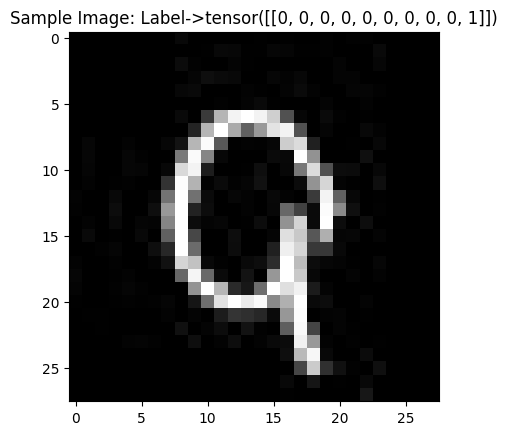

In [138]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.title(f"Sample Image: Label->{label}")
plt.imshow(img.reshape(28,28), cmap="gray")
plt.show()

In [139]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64, 1, 10])


#### Simple Neural Network for Predicting Class of HandWritten Digits

In [295]:
from torch import nn
from torch.nn import functional as F
l = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=5, padding=0)
f = nn.MaxPool2d(3, stride=2)
f2 = nn.Flatten()

In [296]:
#f2(l(train_features)).shape
f2(f(l(train_features))).shape

torch.Size([64, 1210])

In [254]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() #Initializing superclass
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=28, padding=0)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.relu(x)
        x = self.flatten(x)
        out = F.log_softmax(x, dim=1)
        return x

### Training Loop in PyTorch

In [268]:
# Constants
lr = 0.0025
epochs = 50

# Loading Dataset
train_dataset = CustomMNISTDataset('./output/training/')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize Model
model = ConvNet()
# Initialize Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=lr)
# Loss function
loss_fn = nn.CrossEntropyLoss()

# set model to train mode
losses = []
model.train()
for epoch in range(epochs):
	batch_losses = []    
	for batch_idx, (data, targets) in enumerate(train_dataloader):
		optimizer.zero_grad()
		outputs = model(data)
		loss = loss_fn(outputs, targets.squeeze(1).float())
		loss.backward() # Backpropagation of loss
		optimizer.step() # Updating Weights based on Gradients
		batch_losses.append(loss.item())
	final_epoch_loss = torch.mean(torch.Tensor(batch_losses))
	losses.append(final_epoch_loss)
	print(f"{epoch}: {final_epoch_loss}")

0: 2.222630739212036
1: 2.0494024753570557
2: 1.8831391334533691
3: 1.7397220134735107
4: 1.599270224571228
5: 1.4667739868164062
6: 1.3514480590820312
7: 1.2509434223175049
8: 1.1640762090682983
9: 1.089267611503601
10: 1.0245296955108643
11: 0.9676914215087891
12: 0.9178779721260071
13: 0.8744063973426819
14: 0.8364596366882324
15: 0.8024967908859253
16: 0.7725961804389954
17: 0.7459172010421753
18: 0.7218515872955322
19: 0.7000105977058411
20: 0.6803256869316101
21: 0.6624153852462769
22: 0.646346926689148
23: 0.6313562393188477
24: 0.617751955986023
25: 0.6051700115203857
26: 0.5935962200164795
27: 0.582836925983429
28: 0.5727808475494385
29: 0.5635625720024109
30: 0.5548183917999268
31: 0.5466330051422119
32: 0.5390300750732422
33: 0.532080888748169
34: 0.5251561403274536
35: 0.5189392566680908
36: 0.5127766132354736
37: 0.5070438385009766
38: 0.5018283724784851
39: 0.49662721157073975
40: 0.4917532503604889
41: 0.48703885078430176
42: 0.48260778188705444
43: 0.47846081852912903
4

#### Plotting Training Loss and Epoch

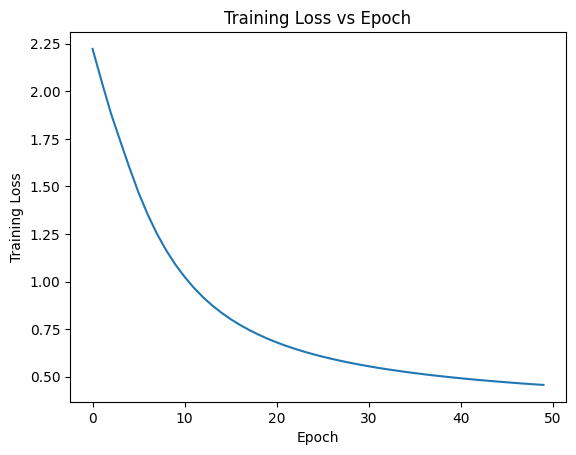

In [269]:
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(range(epochs), losses)
plt.show()

#### Calculating Accuracy

In [270]:
from collections import defaultdict

# Load the test data
test_dataset = CustomMNISTDataset('./output/testing/')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Set model to eval mode
model.eval()

# Loop over dataset to compute accuracy
correct = 0
correct_dict = defaultdict(lambda: [0,0])
for batch_idx, (data, targets) in enumerate(test_dataloader):
    outputs = model(data)
    pred = outputs.argmax(dim=1, keepdim=True) 
    correct += pred.eq(targets.argmax(dim=2).view_as(pred)).sum().item()
    for p, t in zip(pred, targets):
        if p[0] == t.argmax():
            correct_dict[t.argmax().item()][0] += 1
        correct_dict[t.argmax().item()][1] += 1
accuracy = correct / test_dataset.__len__()
print(f"Accuracy: {accuracy}")

Accuracy: 0.8924


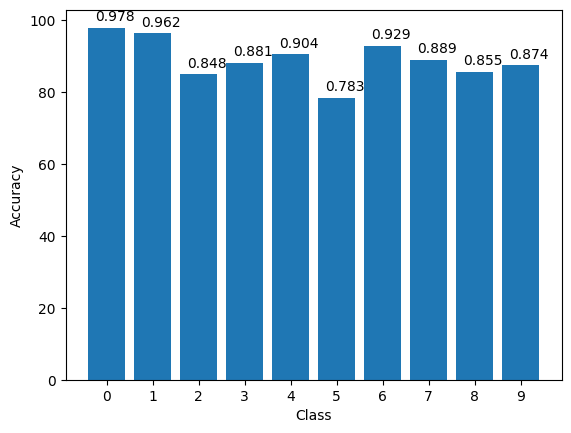

In [271]:
c = [(k, v[0]/v[1]) for k, v in correct_dict.items()]
c.sort(key=lambda x: x[0])
c
plt.bar([ci[0] for ci in c], [ci[1]*100 for ci in c])
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(ticks=[i for i in range(10)])
for i, ci in enumerate(c):
    plt.annotate(str(ci[1])[:5], (i-0.25, ci[1]*100 + 2))
plt.show()

In [272]:
def visTensor(tensor, ch=0, allkernels=False, nrow=5, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(20,20) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='BuPu')
    plt.axis('off')
    plt.show()

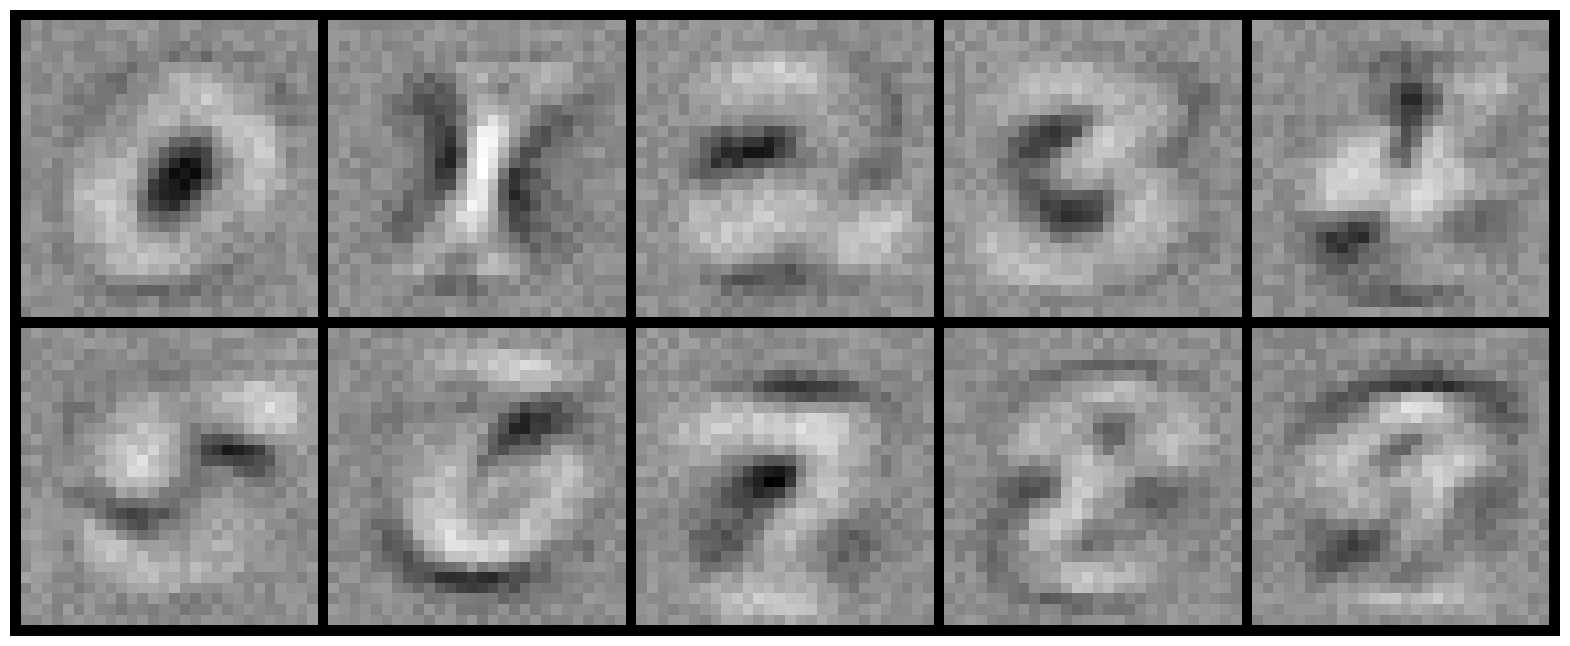

In [273]:
kernels = model.conv_layer.weight.data.clone()
visTensor(kernels, ch=0, allkernels=False)

## New Model with MaxPool Layer and Smaller Kernel

In [301]:
class ConvNetMaxPool(nn.Module):
    def __init__(self):
        super(ConvNetMaxPool, self).__init__() #Initializing superclass
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=5, padding=0) 
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.layer2 = nn.Linear(1210, 10)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.layer2(x)
        out = F.log_softmax(x, dim=1)
        return x

In [302]:
# Constants
lr = 0.0025
epochs = 50

# Loading Dataset
train_dataset = CustomMNISTDataset('./output/training/')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize Model
model = ConvNetMaxPool()
# Initialize Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=lr)
# Loss function
loss_fn = nn.CrossEntropyLoss()

# set model to train mode
losses = []
model.train()
for epoch in range(epochs):
	batch_losses = []    
	for batch_idx, (data, targets) in enumerate(train_dataloader):
		optimizer.zero_grad()
		outputs = model(data)
		loss = loss_fn(outputs, targets.squeeze(1).float())
		loss.backward() # Backpropagation of loss
		optimizer.step() # Updating Weights based on Gradients
		batch_losses.append(loss.item())
	final_epoch_loss = torch.mean(torch.Tensor(batch_losses))
	losses.append(final_epoch_loss)
	print(f"{epoch}: {final_epoch_loss}")

0: 2.11726450920105
1: 1.6861183643341064
2: 1.2227104902267456
3: 0.9150146245956421
4: 0.7427895069122314
5: 0.640465497970581
6: 0.5732887983322144
7: 0.5258785486221313
8: 0.48998594284057617
9: 0.4621153771877289
10: 0.4394333064556122
11: 0.4207530617713928
12: 0.4047263264656067
13: 0.39097267389297485
14: 0.37878280878067017
15: 0.3678332567214966
16: 0.35841143131256104
17: 0.34947502613067627
18: 0.3414694368839264
19: 0.33394911885261536
20: 0.32722458243370056
21: 0.3207947909832001
22: 0.3146950304508209
23: 0.30934005975723267
24: 0.30379316210746765
25: 0.2986851632595062
26: 0.2941092252731323
27: 0.2894502282142639
28: 0.284914493560791
29: 0.2809075713157654
30: 0.2767772972583771
31: 0.273006409406662
32: 0.2690839171409607
33: 0.26542696356773376
34: 0.2620452046394348
35: 0.25861701369285583
36: 0.2552771270275116
37: 0.25210562348365784
38: 0.24906150996685028
39: 0.24607829749584198
40: 0.2433597594499588
41: 0.24015021324157715
42: 0.23767061531543732
43: 0.2347

In [303]:
from collections import defaultdict

# Load the test data
test_dataset = CustomMNISTDataset('./output/testing/')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Set model to eval mode
model.eval()

# Loop over dataset to compute accuracy
correct = 0
correct_dict = defaultdict(lambda: [0,0])
for batch_idx, (data, targets) in enumerate(test_dataloader):
    outputs = model(data)
    pred = outputs.argmax(dim=1, keepdim=True) 
    correct += pred.eq(targets.argmax(dim=2).view_as(pred)).sum().item()
    for p, t in zip(pred, targets):
        if p[0] == t.argmax():
            correct_dict[t.argmax().item()][0] += 1
        correct_dict[t.argmax().item()][1] += 1
accuracy = correct / test_dataset.__len__()
print(f"Accuracy: {accuracy}")

Accuracy: 0.9433


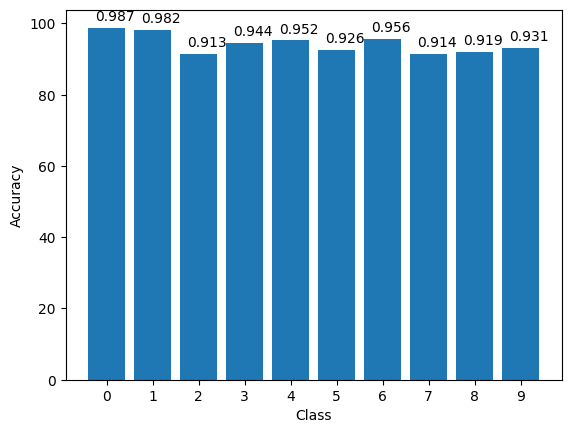

In [304]:
c = [(k, v[0]/v[1]) for k, v in correct_dict.items()]
c.sort(key=lambda x: x[0])
c
plt.bar([ci[0] for ci in c], [ci[1]*100 for ci in c])
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(ticks=[i for i in range(10)])
for i, ci in enumerate(c):
    plt.annotate(str(ci[1])[:5], (i-0.25, ci[1]*100 + 2))
plt.show()

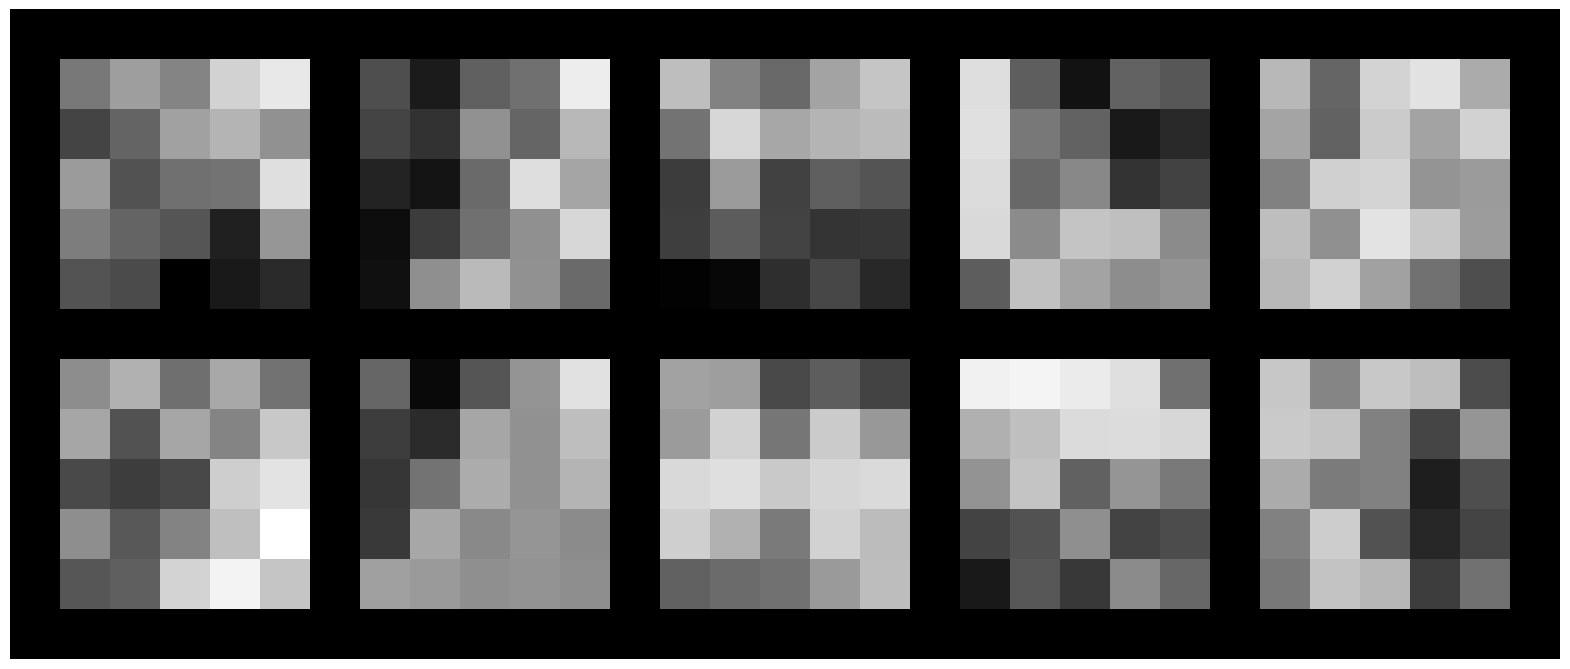

In [305]:
def visTensor(tensor, ch=0, allkernels=False, nrow=5, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(20,20) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)), cmap='BuPu')
    plt.axis('off')
    plt.show()
    
    
kernels = model.conv_layer.weight.data.clone()
visTensor(kernels, ch=0, allkernels=False)